In [1]:
from pandas import read_excel, DataFrame, crosstab
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN
import joblib
import json
from os.path import exists

In [2]:
df = read_excel("IIMK_DSAI_W11_Required Assignment 11.1_Data Set.xlsm")

In [3]:
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
print(df.tail())

     PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q  


In [5]:
# Check if there are any duplicate values in dataset
print(sum(df.duplicated()))

0


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [7]:
na_counts = DataFrame(df.isna().sum(),columns=["NA Counts"]).reset_index()
na_counts = na_counts.rename(columns={'index': 'Column Name'})
print(na_counts)

    Column Name  NA Counts
0   PassengerId          0
1      Survived          0
2        Pclass          0
3          Name          0
4           Sex          0
5           Age        177
6         SibSp          0
7         Parch          0
8        Ticket          0
9          Fare          0
10        Cabin        687
11     Embarked          2


In [8]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Printing unique values in datasets columns
for column in ["Survived","Pclass","Sex","SibSp","Parch","Cabin","Embarked"]:
    print(f"{column}:{df[column].unique()}\n")

Survived:[0 1]

Pclass:[3 1 2]

Sex:['male' 'female']

SibSp:[1 0 3 4 2 5 8]

Parch:[0 1 2 5 3 4 6]

Cabin:[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 

In [10]:
#Printing unique values in dataset columns
for column in ["Survived","Pclass","Sex","SibSp","Parch","Cabin","Embarked"]:
    print(f"{df[column].value_counts()}{df[column].value_counts(normalize=True)}\n")

Survived
0    549
1    342
Name: count, dtype: int64Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Pclass
3    491
1    216
2    184
Name: count, dtype: int64Pclass
3    0.551066
1    0.242424
2    0.206510
Name: proportion, dtype: float64

Sex
male      577
female    314
Name: count, dtype: int64Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64SibSp
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: proportion, dtype: float64

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64Parch
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: proportion, dtype: float64

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7           

In [11]:
# Replacing NA in Age with the mean age
mean_Age = df['Age'].mean()
df['Age'] = df['Age'].fillna(mean_Age)

In [12]:
# As there are several NA in Cabin, for better analysis making another column is_Cabin which is 0 if Cabin is NAN or else 1
df['is_Cabin'] = np.where(df['Cabin'].isna(), 0, 1)
df = df.drop('Cabin', axis = 1)

In [13]:
# Replacing NA in Embarked with the mode
mode_Embarked = df['Embarked'].mode()
df['Embarked'] = df['Embarked'].fillna(mode_Embarked[0])

In [14]:
# Now checking for NA
na_counts = DataFrame(df.isna().sum(),columns=["NA Counts"]).reset_index()
na_counts = na_counts.rename(columns={'index': 'Column Name'})
print(na_counts)

    Column Name  NA Counts
0   PassengerId          0
1      Survived          0
2        Pclass          0
3          Name          0
4           Sex          0
5           Age          0
6         SibSp          0
7         Parch          0
8        Ticket          0
9          Fare          0
10     Embarked          0
11     is_Cabin          0


In [15]:
# Printing unique values in datasets columns
for column in ["Survived","Pclass","Sex","SibSp","Parch","is_Cabin","Embarked"]:
    print(f"{column}:{df[column].unique()}\n")

Survived:[0 1]

Pclass:[3 1 2]

Sex:['male' 'female']

SibSp:[1 0 3 4 2 5 8]

Parch:[0 1 2 5 3 4 6]

is_Cabin:[0 1]

Embarked:['S' 'C' 'Q']



In [16]:
#Printing unique values in dataset columns
for column in ["Survived","Pclass","Sex","SibSp","Parch","is_Cabin","Embarked"]:
    print(f"{df[column].value_counts()}{df[column].value_counts(normalize=True)}\n")

Survived
0    549
1    342
Name: count, dtype: int64Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Pclass
3    491
1    216
2    184
Name: count, dtype: int64Pclass
3    0.551066
1    0.242424
2    0.206510
Name: proportion, dtype: float64

Sex
male      577
female    314
Name: count, dtype: int64Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64SibSp
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: proportion, dtype: float64

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64Parch
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: proportion, dtype: float64

is_Cabin
0    687
1    204
Name: count, dtype: int64is_Cabin
0    0.771044
1    0.228956
Name: proportion, dtype: float64

Embarked
S    6

<h1>Exploratory Data Analysis</h1>

<p>As we know that females, elderly and children were preferred to be saved via lifeboats let us check the survival on basis of these two parameters. Then let us analyze it in terms of Pclass to check if there was a preference to save 1st class passengers.</p>

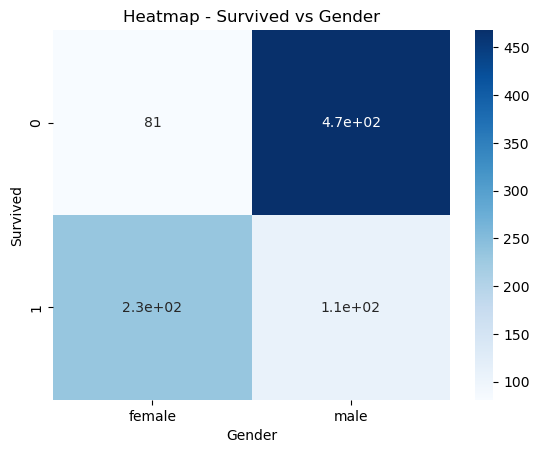

In [17]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Survived'], df['Sex']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Gender')
plt.ylabel('Survived')
plt.title('Heatmap - Survived vs Gender')
plt.show()

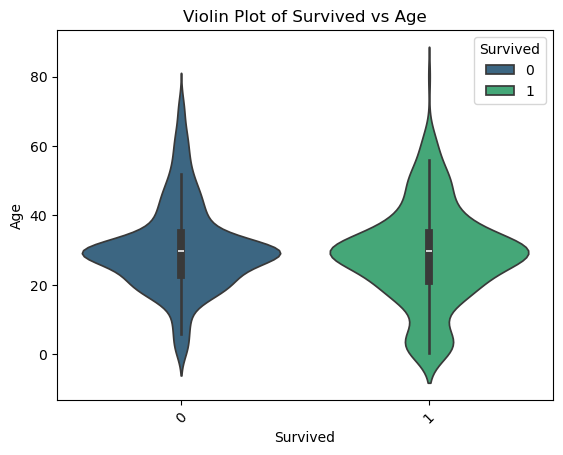

In [18]:
 # Create the violin plot
sns.violinplot(x = "Survived",
               y = "Age",
               data = df,
               hue = "Survived",
               palette = "viridis")

# Customize the plot
plt.xlabel("Survived")
plt.ylabel("Age")
plt.title("Violin Plot of Survived vs Age")
plt.xticks(rotation=45)
plt.show()

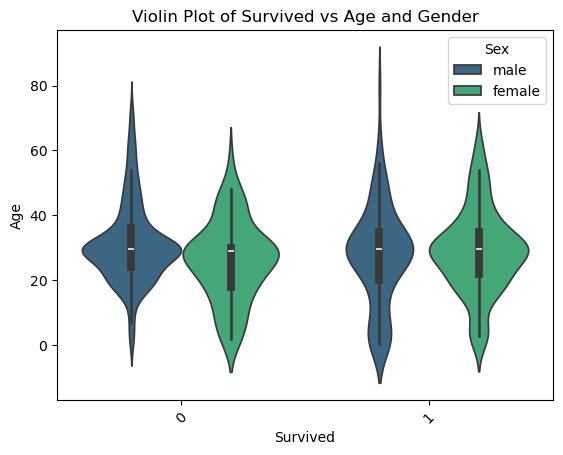

In [19]:
 # Create the violin plot
sns.violinplot(x = "Survived",
               y = "Age",
               data = df,
               hue = "Sex",
               palette = "viridis")

# Customize the plot
plt.xlabel("Survived")
plt.ylabel("Age")
plt.title("Violin Plot of Survived vs Age and Gender")
plt.xticks(rotation=45)
plt.show()

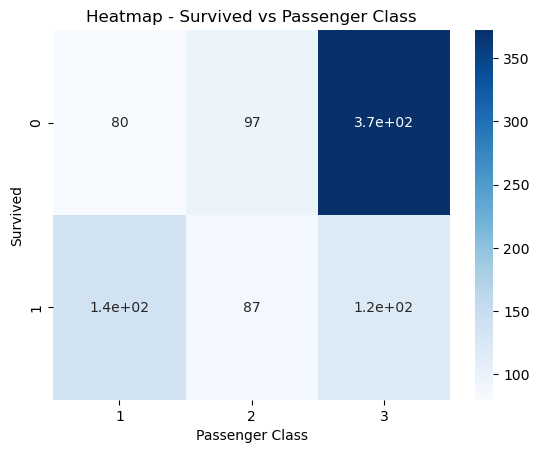

In [20]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Survived'], df['Pclass']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Passenger Class')
plt.ylabel('Survived')
plt.title('Heatmap - Survived vs Passenger Class')
plt.show()

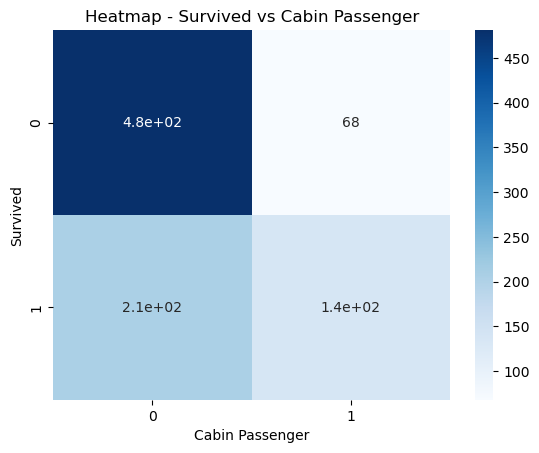

In [21]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Survived'], df['is_Cabin']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Cabin Passenger')
plt.ylabel('Survived')
plt.title('Heatmap - Survived vs Cabin Passenger')
plt.show()

<p>We see a clear indication that female passengers are more likely to survive. Children and the Elderly were also more likely to survive especially in males. Passengers in 1st Class are more likely to survive than passengers in 2nd Class and 3rd Class. Passengers in Cabin are also more likely to survive than passengers not having cabin tickets.</p>

<h1>Splitting the Training and Testing Data Set</h1>

In [22]:
# The only features we will use for further modelling - SibSp, Pclass, Sex, Age, Parch, is_Cabin and Embarked
X,y = df.drop(["PassengerId","Name","Ticket","Survived"],axis=1), df["Survived"]

# Split data into training and testing sets (default test_size=0.25) # Through trial and error this was found to be the best split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [23]:
print("Training Data Shape")
print(X_train.shape)
print("Testing Data Shape")
print(X_test.shape)

Training Data Shape
(668, 8)
Testing Data Shape
(223, 8)


In [24]:
# Define column names
ordinal_cols = ['Sex']
onehot_cols = ['Embarked']
numerical_cols = [col for col in X.columns if col not in ordinal_cols + onehot_cols]

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), ordinal_cols),
        ('onehot', OneHotEncoder(), onehot_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

<Axes: >

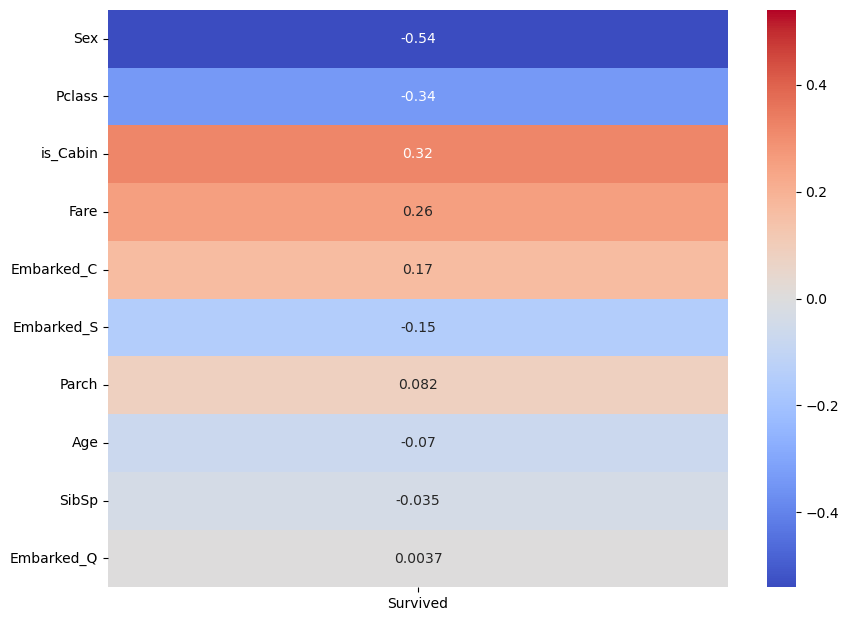

In [25]:
transformed_df = preprocessor.fit_transform(df.drop(["PassengerId","Name","Ticket"],axis=1))
transformed_df = DataFrame(transformed_df, columns=['Sex', 'Embarked_C', 'Embarked_Q', 'Survived', 'Pclass', 'Age', 'SibSp','Parch','Fare','is_Cabin'])
transformed_df["Survived"] = df["Survived"].astype(float)
transformed_df["Embarked_S"] = transformed_df.apply(lambda row: 1.0 if row['Embarked_C'] == 0.0 and row['Embarked_Q'] == 0.0 else 0.0, axis=1)

corr = transformed_df.corr()
norm = Normalize(vmin=-0.54, vmax=0.54)
plt.figure(figsize=(10, 7.5))
sns.heatmap(corr["Survived"].to_frame().sort_values(by="Survived", key=lambda x: x.abs(), ascending=False).iloc[1:11,:],
            annot=True, cmap = "coolwarm",norm = norm)

<p> As per the above heatmap we can analyze the feature importance and correlation with the target variable Survived. By this analysis, we find the maximum importance is of gender followed by Passenger Class, whether the passenger has a cabin ticket and fare. The other features have relatively lesser importance due to its low correlation with the target variable.

<h1> SVM </h1>

In [26]:
# If model already run from the existing model or else define the model
if exists ('svm_model.joblib'):
    print("Loading from file")
    svm_loaded = joblib.load('svm_model.joblib')
    y_pred_svm = svm_loaded.predict(X_test)
    y_pred_proba_svm = svm_loaded.predict_proba(X_test)
    with open('svm_results.json', 'r') as json_file:
        results = json.load(json_file)
        optimal_params = results['optimal_params']
        optimal_accuracy = results['optimal_accuracy']
        print(f'Best parameters: {optimal_params}')
        print(f'Best cross-validation accuracy: {optimal_accuracy:.5f}')
else:   
    # Define the pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),  # Apply scaling to all columns after preprocessing
        ('smote_svm', SVMSMOTE(random_state=21)),
        ('svm', SVC(probability=True))
    ])

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'svm__C': np.arange(0.25, 1.8, 0.25),
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    }

    # Define the GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, njobs = -1)

    # Perform GridSearchCV to find the best parameters and fit the model
    grid_search.fit(X_train, y_train)

    # Update the pipeline with the best estimator
    optimal_estimator = grid_search.best_estimator_

    y_pred_svm = optimal_estimator.predict(X_test)
    y_pred_proba_svm = optimal_estimator.predict_proba(X_test)

    # Print the best parameters and cross-validation accuracy
    print(f'Best parameters: {(optimal_params:= grid_search.best_params_)}')
    print(f'Best cross-validation accuracy: {(optimal_accuracy:= grid_search.best_score_):.5f}')

    # Writing it in json file
    results = {'optimal_params': optimal_params, 'optimal_accuracy': optimal_accuracy}
    with open('svm_results.json', 'w') as json_file:
        json.dump(results, json_file)

    # Save the pipeline
    joblib.dump(optimal_estimator, 'svm_model.joblib')
    print("Model trained and saved to disk.")


Loading from file
Best parameters: {'svm__C': 1.5, 'svm__kernel': 'rbf'}
Best cross-validation accuracy: 0.82781


<h2> Model Evaluation </h2>

In [27]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"The accuracy of SVM model is {accuracy_svm:5f}")

The accuracy of SVM model is 0.825112


In [28]:
print(confusion_matrix(y_test, y_pred_svm))

[[122  11]
 [ 28  62]]


In [29]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       133
           1       0.85      0.69      0.76        90

    accuracy                           0.83       223
   macro avg       0.83      0.80      0.81       223
weighted avg       0.83      0.83      0.82       223



In [30]:
f1_svm = f1_score(y_test,y_pred_svm)
print(f"The f1 score of SVM model is {f1_svm:5f}")

The f1 score of SVM model is 0.760736


In [31]:
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm[:,1])
print(f"The ROC-AUC score of SVM model is {roc_auc_svm:5f}")

The ROC-AUC score of SVM model is 0.854511


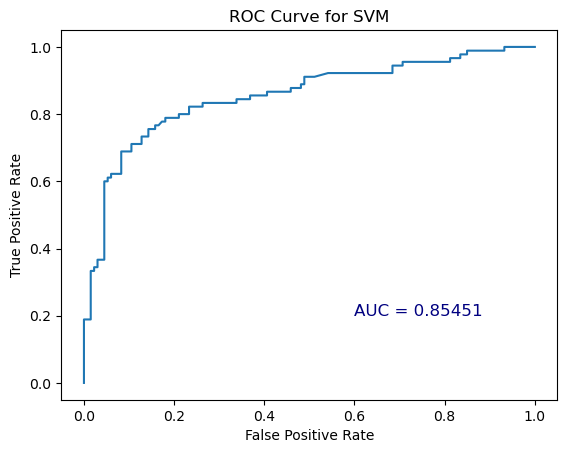

In [32]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm[:, 1])
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.5f})'.format(roc_auc_svm))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.text(0.6, 0.2, f'AUC = {roc_auc_svm:.5f}', fontsize=12, color='navy')
plt.show()

<h1>Gaussian Naive Bayes</h1>

In [33]:
# If model already run from the existing model or else define the model
if exists ('gnb_model.joblib'):
    print("Loading from file")
    gnb_loaded = joblib.load('gnb_model.joblib')
    y_pred_gnb = gnb_loaded.predict(X_test)
    y_pred_proba_gnb = gnb_loaded.predict_proba(X_test)

else:   
    # Define the pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', ADASYN(random_state=21)),
        ('scaler', StandardScaler()),  # Apply scaling to all columns after preprocessing
        ('gnb', GaussianNB())
    ])

    pipeline.fit(X_train, y_train)

    y_pred_gnb = pipeline.predict(X_test)
    y_pred_proba_gnb = pipeline.predict_proba(X_test)

    # Save the pipeline
    joblib.dump(pipeline, 'gnb_model.joblib')
    print("Model trained and saved to disk.")

Loading from file


<h1> Model Evaluation </h1>

In [34]:
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"The accuracy of Gaussian Naive Bayes model is {accuracy_gnb:5f}")

The accuracy of Gaussian Naive Bayes model is 0.807175


In [35]:
print(confusion_matrix(y_test, y_pred_gnb))

[[105  28]
 [ 15  75]]


In [36]:
print(classification_report(y_test,y_pred_gnb))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       133
           1       0.73      0.83      0.78        90

    accuracy                           0.81       223
   macro avg       0.80      0.81      0.80       223
weighted avg       0.82      0.81      0.81       223



In [37]:
f1_gnb = f1_score(y_test,y_pred_gnb)
print(f"The f1 score of Gaussian Naive Bayes model is {f1_gnb:5f}")

The f1 score of Gaussian Naive Bayes model is 0.777202


In [38]:
roc_auc_gnb = roc_auc_score(y_test, y_pred_proba_gnb[:,1])
print(f"The ROC-AUC score of GNB model is {roc_auc_gnb:5f}")

The ROC-AUC score of GNB model is 0.845405


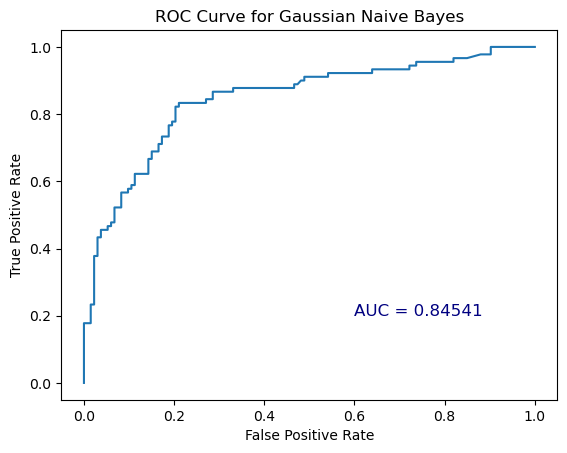

In [39]:
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_pred_proba_gnb[:, 1])
plt.plot(fpr_gnb, tpr_gnb, label='GNB (AUC = {:.5f})'.format(roc_auc_gnb))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian Naive Bayes')
plt.text(0.6, 0.2, f'AUC = {roc_auc_gnb:.5f}', fontsize=12, color='navy')
plt.show()

<h1>Comparision of Models</h1>

In [40]:
metrics = DataFrame({"SVM":[accuracy_svm, f1_svm, roc_auc_svm],
                     "GNB":[accuracy_gnb, f1_gnb, roc_auc_gnb]},
                    index = ["Accuracy", "F1 Score", "ROC AUC Score"])
metrics = metrics.rename_axis('Metrics')
display(metrics)



,SVM,GNB
Metrics,,
Accuracy,0.825112,0.807175
F1 Score,0.760736,0.777202
ROC AUC Score,0.854511,0.845405


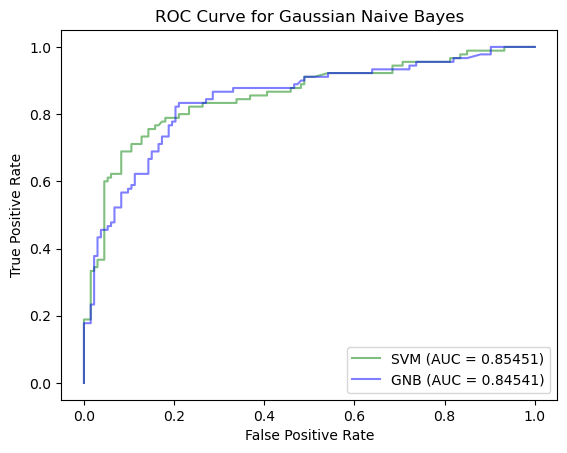

In [41]:
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.5f})'.format(roc_auc_svm), color = "green", alpha = 0.5)
plt.plot(fpr_gnb, tpr_gnb, label='GNB (AUC = {:.5f})'.format(roc_auc_gnb),color = "blue", alpha = 0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian Naive Bayes')
plt.legend(loc='lower right')
plt.show()